# Getting archived weather data for US station data 

This script defines a function that downloads daily weather data from weather stations from the Global Historical Climate Network - Daily(GHCND).
The data server that allows us a convenient access to the daily data is located at the Applied Climate Information System (ACIS). ACIS is developed, maintained, and operated by the NOAA Regional Climate Centers (RCCs). [http://data.rcc-acis.org](http://data.rcc-acis.org)

Here we demonstrate how we send a data request to the server.
The server responds to our request and sends the data back in a format that we need to 'unpack' put our data into numpy arrays. Fortunately, all that has been solved already and code exists that we can simply reuse here.

In the code below we have selected the station Albany Airport (KALB). The GHCN station idenifier is 

__'USW00014735'__

We can get for example: 
- avgt: daily average temperature (F)
- tmin: daily minimum temperature (F)
- tmax: daily maximum temperature (F)

Try it yourself in a browser window use the http-link with the data query string appended:

[http://data.rcc-acis.org/StnData?sid=USW00014735&&sdate=2018-01-1&&edate=2018-12-31&interval=dly&elems=avgt](http://data.rcc-acis.org/StnData?sid=USW00014735&&sdate=2018-01-1&&edate=2018-12-31&interval=dly&elems=avgt)

This will return daily mean temperatures from ALbany Airport for the year 2018.


## Code development

__You may wonder: "How can I do such a thing with Python?"__

__The answer lies in the package urllib3! This package is allowing us to send and receive data via the http-protocol directly and without a web-browser!__

In addition, people have developed a package that helps to deal with the JSON text data format that the server side uses to return the data. JSON is becoming more and more used for data exchange via http/ internet.



In [1]:
# request a station time series
# from Applied Climate Information System
# http://www.rcc-acis.org/index.html
# Author: OET
# code designed for ATM315/ENV315 Python introduction

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import urllib3
import json
import datetime as dt
#########################################################################################################
# defining a function to allow us to make more than just one specific data request
# it allows flexibilty in terms of station, variable, start and end year
# It first creates the http-string and uses the urllib3 functions to transmit the request to the server
# Then it receives the data in the JSON text format and converts it into a nested list object
# That's where we had to put some work in to extract the dates and data values and put them into lists
# two lists are returned, one with the dates (NEW object type 'datetime'!) and teh numerical values.
#########################################################################################################
def get_stationdata_monthly(sid,var='avgt',startyear=2017,endyear=2017):
    """Sends request to regional climate center ACIS and gets monthly data for one station.
    Input parameters: 
        sid (string): a station id
        var (string): a variable name (e.g. 'avgt', 'mint', 'maxt')
    Optional parameters:
        startyear and endyear (integers): for selecting the year range e.g. 1950 and 2017
    
    Returned objects:
        list with dates (datetime objects)
        list with the data 
    """    
    # the http address of the data server
    host="http://data.rcc-acis.org/StnData"
    # forming the query string for the host server
    sdate='&sdate='+str(startyear)+'-01-1'
    edate='&edate='+str(endyear)+'-12-31'
    query='?sid='+sid+'&'+sdate+'&'+edate+'&interval=mly&'\
    +'elems='+"mly_mean_"+var
    # try to connect and to get the requested data
    # in format ready to export to a csv file
    print (">send data request to "+host+query)
    print ("> still waiting for response ...")
    try:
        http= urllib3.PoolManager()
        response = http.request('GET',host+query)
        # convert json-string into dictionary
        content =  json.loads(response.data.decode('utf-8'))
        meta=content['meta']
        data=content['data']
        time=[]
        value=[]
        for item in data:
            #print (item)
            time.append(dt.datetime.strptime(item[0],"%Y-%m"))
            if (item[1]!='M'):
                value.append(float(item[1]))
            else:
                value.append(np.NAN)
    except Exception as e:
        print ("error occurred:", e)
        return
    print(">... done")
    return time,value

In [3]:
print(help(get_stationdata_monthly))

Help on function get_stationdata_monthly in module __main__:

get_stationdata_monthly(sid, var='avgt', startyear=2017, endyear=2017)
    Sends request to regional climate center ACIS and gets monthly data for one station.
    Input parameters: 
        sid (string): a station id
        var (string): a variable name (e.g. 'avgt', 'mint', 'maxt')
    Optional parameters:
        startyear and endyear (integers): for selecting the year range e.g. 1950 and 2017
    
    Returned objects:
        list with dates (datetime objects)
        list with the data

None


In [4]:
x,y=get_stationdata_monthly("USW00014735",'avgt',startyear=1900,endyear=2018)

>send data request to http://data.rcc-acis.org/StnData?sid=USW00014735&&sdate=1900-01-1&&edate=2018-12-31&interval=mly&elems=mly_mean_avgt
> still waiting for response ...
>... done


30


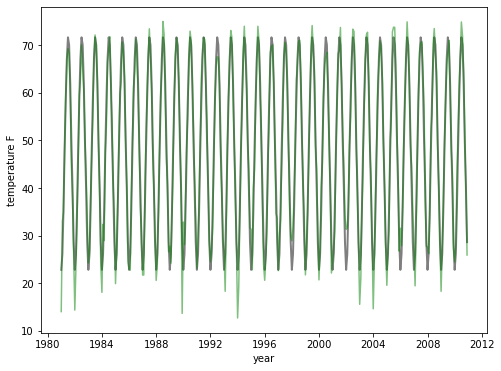

In [5]:
year, month=[], []
x=np.array(x)
y=np.array(y)

for date in x:
    year.append(date.year)
    month.append(date.month)
year=np.array(year)
month=np.array(month)

isclim=np.logical_and(year>1980,year<2011)
yhelp=y[isclim]
iyr=int(np.sum(isclim)/12)
print(iyr)
plt.figure(figsize=[8,6])

plt.xlabel("year")
plt.ylabel("temperature F")
yclim=np.reshape(y[isclim],newshape=[iyr,12])
yclimmean=np.mean(yclim,axis=0)
plt.plot(x[isclim],np.tile(yclimmean,iyr),color='black',linewidth=2,alpha=0.5)
plt.plot(x[isclim],y[isclim],alpha=0.5,color='green')
plt.show()



<BarContainer object of 177 artists>

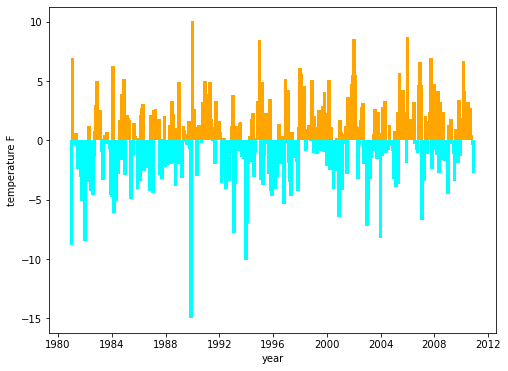

In [6]:
anom=y[isclim]-np.tile(yclimmean,iyr)
plt.figure(figsize=[8,6])
plt.xlabel("year")
plt.ylabel("temperature F")
xhelp=x[isclim]
is_pos=anom>0
is_neg= anom<0
plt.bar(xhelp[is_pos],anom[is_pos],color='orange',width=100)
plt.bar(xhelp[is_neg],anom[is_neg],color='cyan',width=100)

119


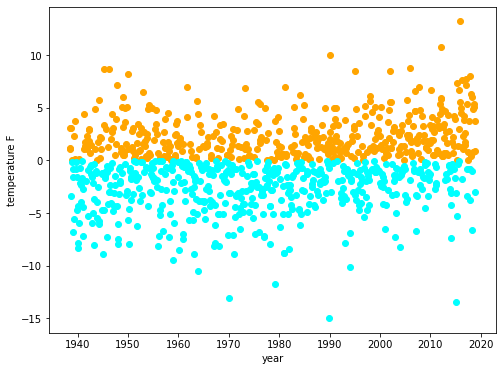

In [7]:
iyr=int(np.size(y)/12)
print(iyr)
anom=y-np.tile(yclimmean,iyr)
plt.figure(figsize=[8,6])
plt.xlabel("year")
plt.ylabel("temperature F")
xhelp=x
is_pos=anom>0
is_neg= anom<0
plt.plot(xhelp[is_pos],anom[is_pos],'o',color='orange')
plt.plot(xhelp[is_neg],anom[is_neg],'o',color='cyan')

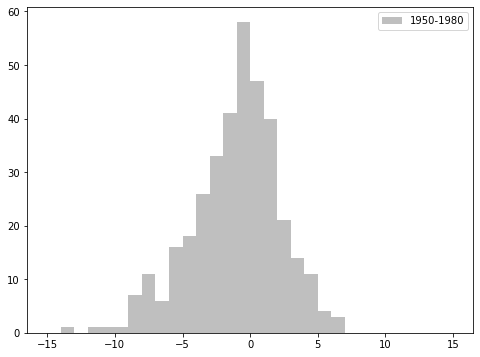

In [8]:
i1=np.logical_and(year>1950,year<1981)
i2=np.logical_and(year>1988,year<2019)
iyr1=int(np.sum(i1)/12)
iyr2=int(np.sum(i2)/12)

anom1=y[i1]-np.tile(yclimmean,iyr1)
anom2=y[i2]-np.tile(yclimmean,iyr2)
plt.figure(figsize=[8,6])
bin_edges=np.arange(-15,16,1)
plt.hist(anom1,bins=bin_edges,color='gray',label="1950-1980",alpha=0.5)
plt.legend()
plt.show()

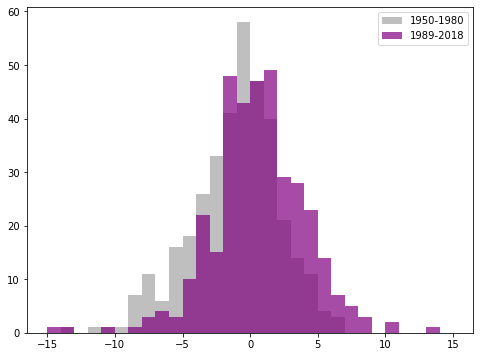

In [9]:
plt.figure(figsize=[8,6])
bin_edges=np.arange(-15,16,1)
plt.hist(anom1,bins=bin_edges,color='gray',label="1950-1980",alpha=0.5)
plt.hist(anom2,bins=bin_edges,color='purple',label='1989-2018',alpha=0.7)
plt.legend()
plt.show()

### Further References:
- [GHCND](https://www.ncdc.noaa.gov/ghcn-daily-description)
- FTP site with station ids etc: ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/